# Replicating signal processing in other papers using CTU-CHB dataset in deep learning models

## Set-up

In [1]:
# Import packages
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal
from scipy import interpolate
from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import plot, imshow

## ✖ Bursa and Lhotska et al. 2017 - The Use of Convolutional Neural Networks in Biomedical Data Processing
* Example uses record 1001 with no filtering or artifact removal
* Morlet wavelet with "w" or "ω" (omega) parameter as 4 or 8
* Scaleogram y axis includes:
    * 10 to the power of 0 = 1
    * 10 to the power of -1 = 1/10
    * 10 to the power of -2 = 1/100
* Given that scale and frequency are inversely proportional, I'm presuming this is likely plotting frequencies and so:
    * Frequency 1 = 1
    * Frequency 1/10 = 10
    * Frequency 1/100 = 100
* It appears to be a on a logarithmic scale
* Scaleogram plots are 5000 to 19000. Signal plots have no x axis

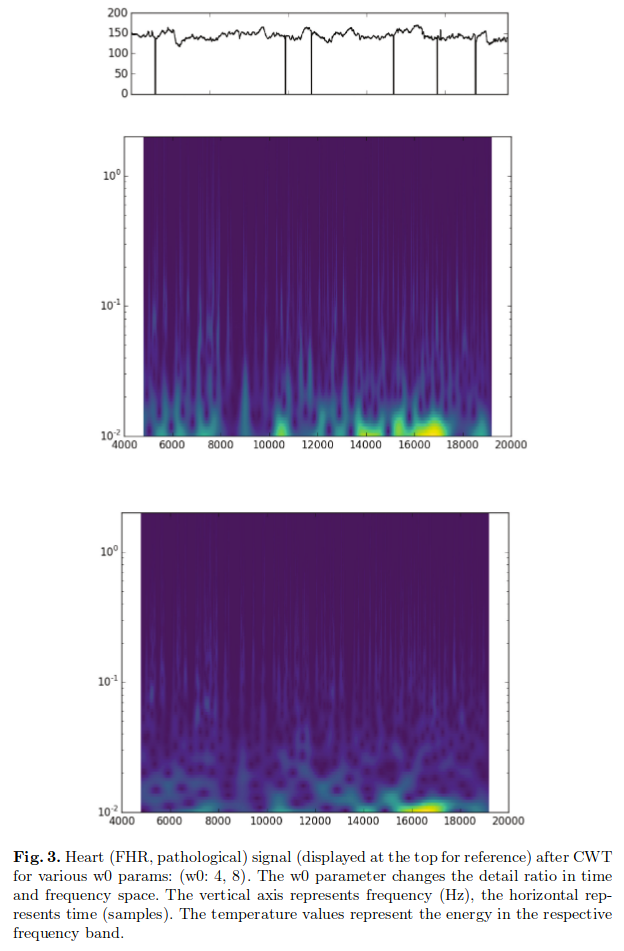

In [2]:
# Source: https://link.springer.com/chapter/10.1007/978-3-319-64265-9_9
Image('images/bursa_figure3.png')

It is unclear why this looks so different to their signal, since it is using the same record and time points with no other changes to the signal.

In [3]:
# Import the matching data
ctg = pd.read_csv('data_csv/1001.csv')
raw_fhr = ctg['FHR']

# Trim it to the same time range as in the figure
trim_fhr = raw_fhr[5000:19001]

Text(0, 0.5, 'FHR (bpm)')

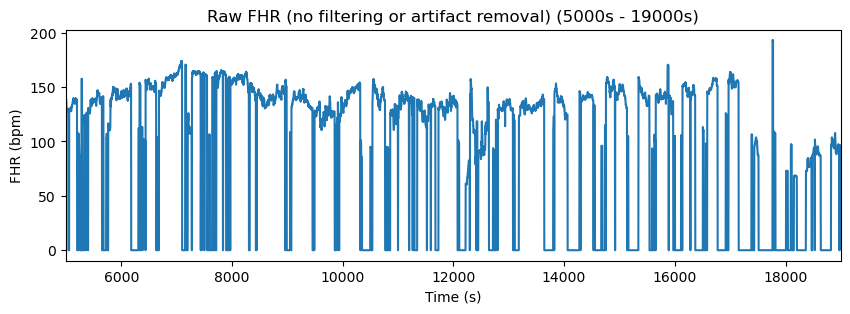

In [4]:
# Plot the signal
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(trim_fhr)
ax.margins(x=0)
ax.set_title('Raw FHR (no filtering or artifact removal) (5000s - 19000s)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('FHR (bpm)')

Ssqueezepy takes mu for morlet, and although mu and omega are related, it's difficult to convert between them due to the complex exponential term in the morlet wavelet formula that involves both values.

I've created plots with some values of mu within the recommend range of 4 to 16, but the plots do not appear similar to the paper.

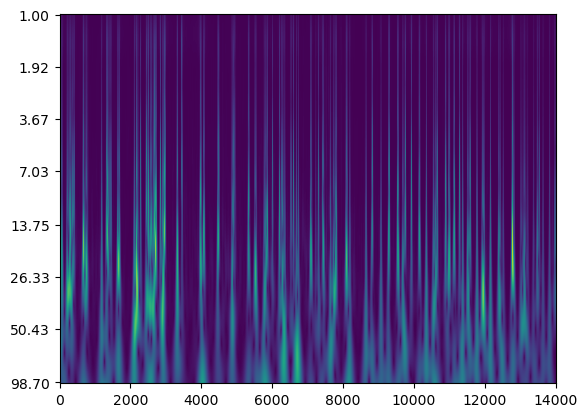

In [5]:
# Set signal parameters
signal_length = len(trim_fhr)
wavelet = Wavelet(('morlet', {'mu': 4}))

# Find scales
scales = make_scales(signal_length, scaletype='log', min_scale=1, max_scale=100)

# Perform CWT
Wx, _ = cwt(trim_fhr, wavelet, scales=scales)

# Visualise
imshow(data=Wx, abs=1, cmap='viridis', yticks=scales)

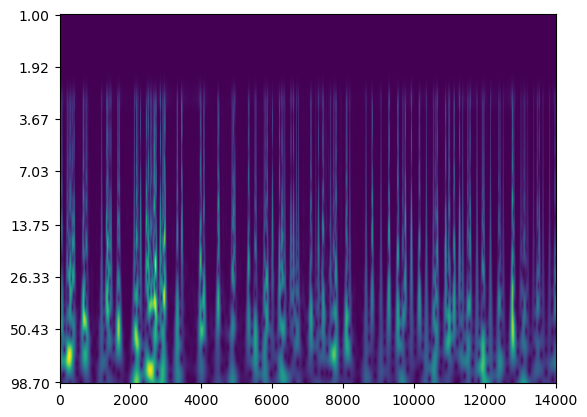

In [6]:
# Set signal parameters
signal_length = len(trim_fhr)
wavelet = Wavelet(('morlet', {'mu': 9}))

# Find scales
scales = make_scales(signal_length, scaletype='log', min_scale=1, max_scale=100)

# Perform CWT
Wx, _ = cwt(trim_fhr, wavelet, scales=scales)

# Visualise
imshow(data=Wx, abs=1, cmap='viridis', yticks=scales)

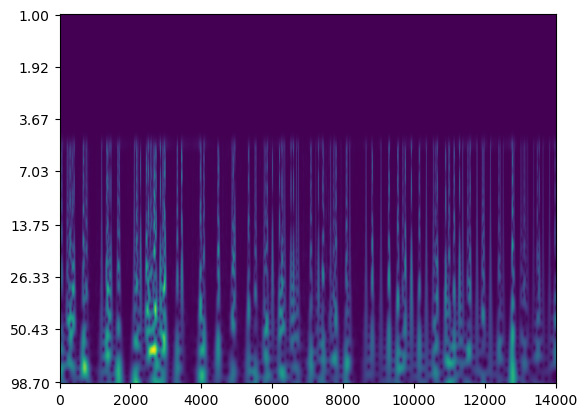

In [7]:
# Set signal parameters
signal_length = len(trim_fhr)
wavelet = Wavelet(('morlet', {'mu': 16}))

# Find scales
scales = make_scales(signal_length, scaletype='log', min_scale=1, max_scale=100)

# Perform CWT
Wx, _ = cwt(trim_fhr, wavelet, scales=scales)

# Visualise
imshow(data=Wx, abs=1, cmap='viridis', yticks=scales)

In scipy.signal, they accept input of omega, but also require values for M and sigma, which the paper doesn't provide. Hence, I have also just tried running with scipy.signal's default morlet2 function.

This likewise doesn't match up with the paper image.

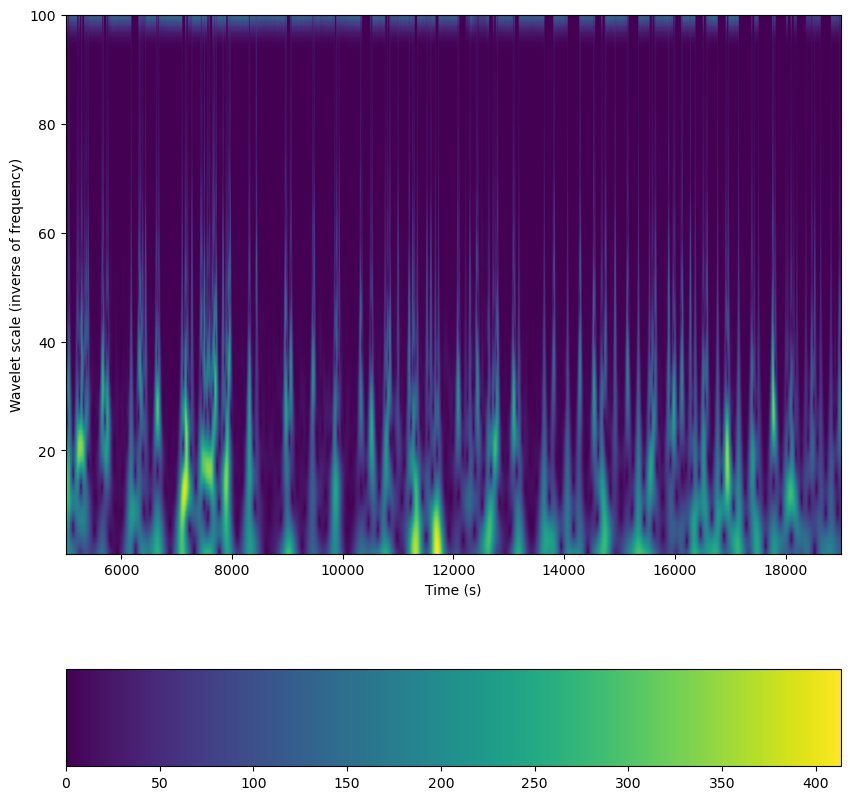

In [8]:
# Generate a log scale from 1 to 100
log_scale = np.logspace(0, 2, num=100)

# Perform CWT
cwtmatr = signal.cwt(trim_fhr, signal.morlet2, log_scale)

# Find absolute values
magn = np.absolute(cwtmatr)

# Plot scaleogram
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(
    magn,
    extent=[min(trim_fhr.index), max(trim_fhr.index), 1, 100],
    aspect='auto',)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Wavelet scale (inverse of frequency)')
plt.colorbar(im, ax=ax, orientation='horizontal', aspect=8)
plt.show()

## ✖ Comert and Kocamaz 2018 - Fetal Hypoxia Detection Based on Deep Convolutional Neural Network with Transfer Learning Approach

Pre-processing:
* Remove gaps greater than 15s
* Using cubic spine interpolation to fill small gaps
* Use standard median filter to lightly soften (with loss of variability)
* Use outlier detection algorithm from Romano, M., Faiella, G., Bifulco, P., D’Addio, G., Clemente, F., Cesarelli, M.: Outliers detection and processing in CTG monitoring. In: Roa Romero, L.M. (ed.) XIII Mediterranean Conference on Medical and Biological Engineering and Computing 2013, MEDICON 2013, Seville, Spain, 25–28 September 2013, pp. 651–654. Springer, Cham (2014). This algorithm involves detection of local outliers (cardiac arrhythmias and short time artifacts) and global outliers (signal losses). Local outliers are from forward and backward scan of signal with 2 different thresholds according to signal quality, where outlier exceeds threshold with reference value being median on five samples (?). Global outliers are preceded and followed by intervals with opposite monotony
* De-trend signal (as using non-linear techniques, so want to preserve dynamics in nature of FHR signals)

Transformation:
* Short Time Fourier Transform (STFT)
* Use four frequency intervals: 0-0.03Hz, 0.03-0.15Hz, 0.15-0.5Hz, and 0.5-1Hz. These intervals are associated with some physical events - lower frequency are fetal maturation, moderate frequency are fetal movements and maternal respiration, and high frequency are parasympathetic nervous system fluctuations.

Not sure:
* What record is used to produce the example figures
* What parameters were used for spectogram generation

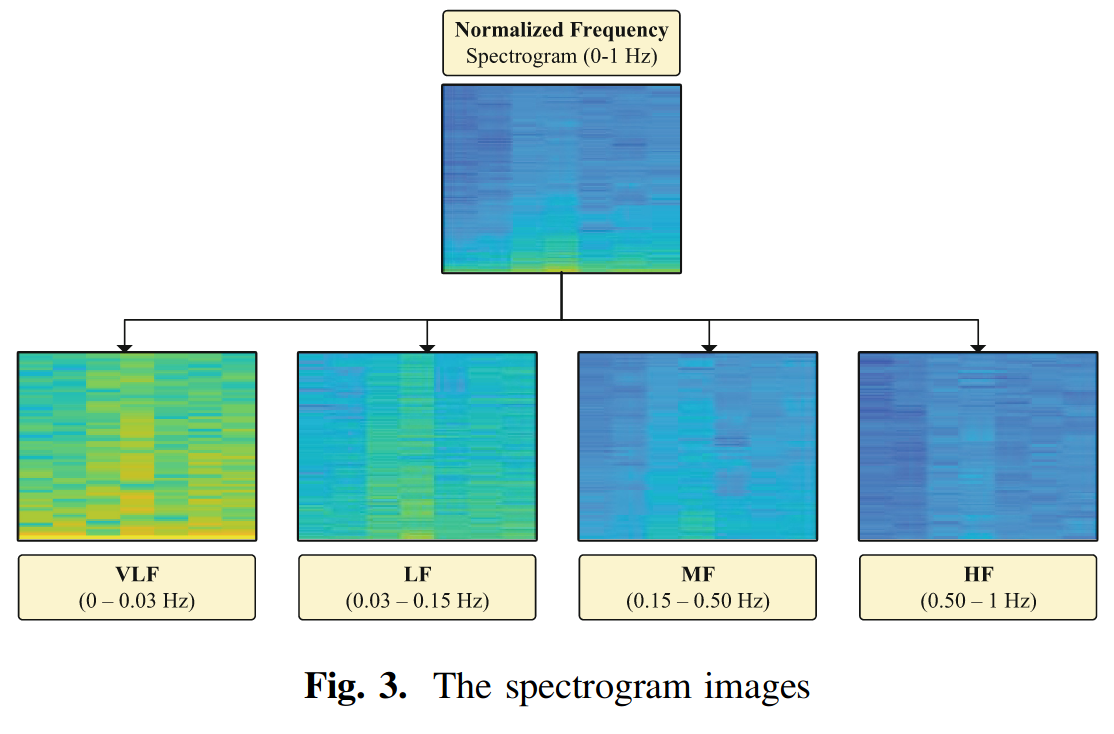

In [9]:
Image('images/comert_figure3.png')

In [10]:
# Import some FHR data
ctg = pd.read_csv('data_csv/1001.csv')
raw_fhr = ctg['FHR']

Using my current cleaning function - doesn't match their whole process

In [11]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Clip to last 90 minutes
    fhr = fhr.tail(90*60)

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    return(fhr)


fhr = clean_fhr(raw_fhr)

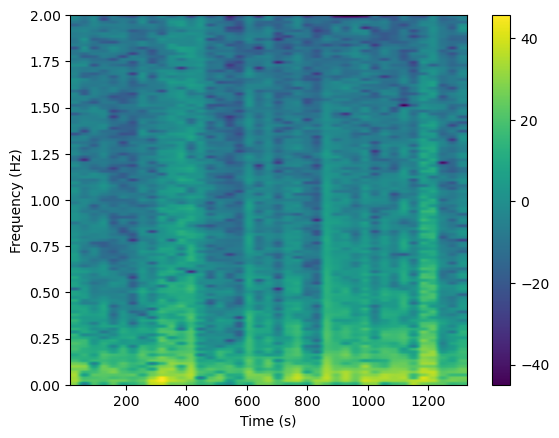

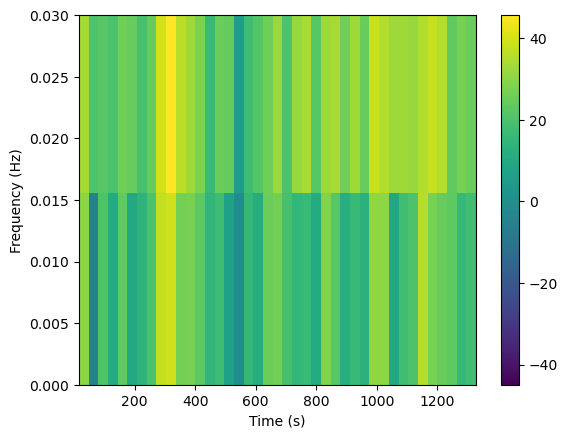

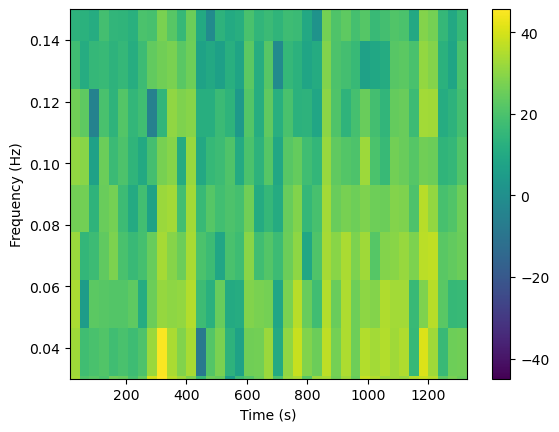

In [12]:
plt.specgram(fhr, NFFT=256, Fs=4, detrend='linear')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.specgram(fhr, NFFT=256, Fs=4, detrend='linear')
plt.colorbar()
plt.ylim(0, 0.03)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

plt.specgram(fhr, NFFT=256, Fs=4, detrend='linear')
plt.colorbar()
plt.ylim(0.03, 0.15)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## ✔ Daydulo et al. 2022 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study

Signal pre-processing:
* Long gaps (more than 15s) removed from the signal
* Missing values at beginning and end of recording excluded to start from the stable point
* Outside 50bpm or 200bpm are outliers
* Outliers and small gaps were find and linearly interpolated using Matlab
* Spikes are when beat is more than 25 from previous adjacent beat (not physiologic, unreliable) so removed using cubic spline interpolation.

Selected segment of the first 20 minutes (4800) and last 15 minutes (3600) to use and represent first and second stage of labour

CWT:
* Appears to be MATLAB
* Generalised Morse wavelet
* Sampling frequency 4 Hz
* Signal length (4800 and 3600) gamma (γ) parameter 3
* Time bandwidth product (P-squared) value 60, 55
* Voice for octave value of 12

Not sure which record used for creation of figures.

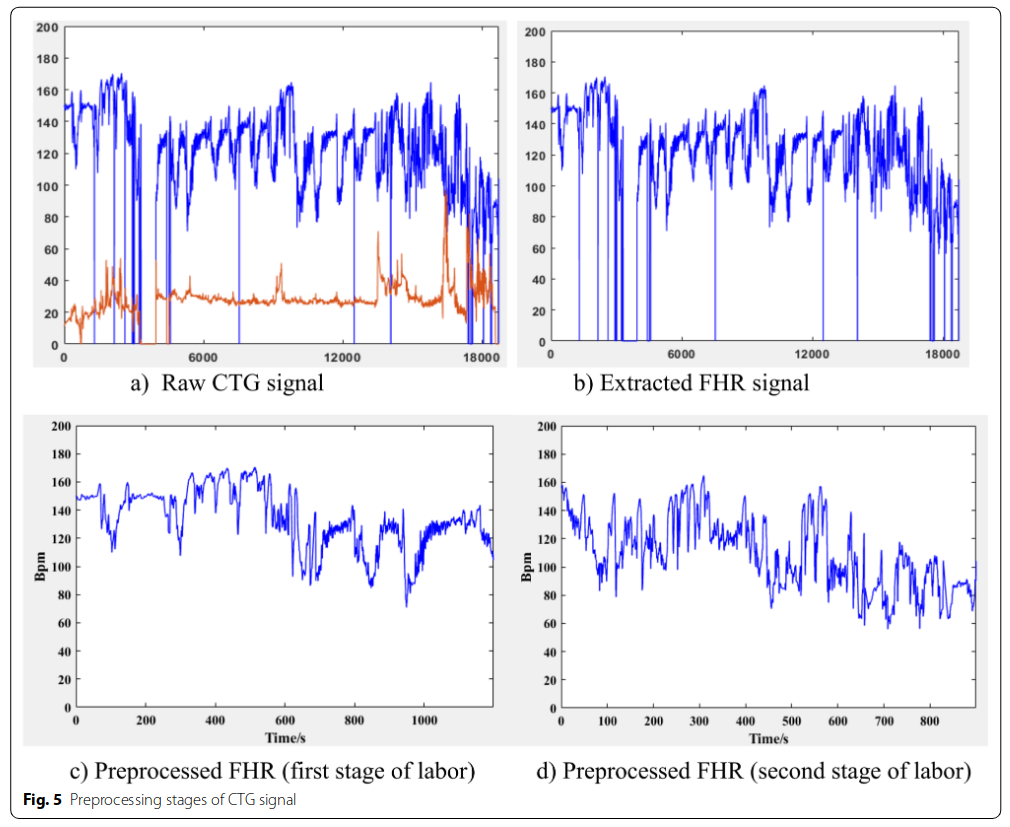

In [13]:
Image('images/daydulo_figure5.png')

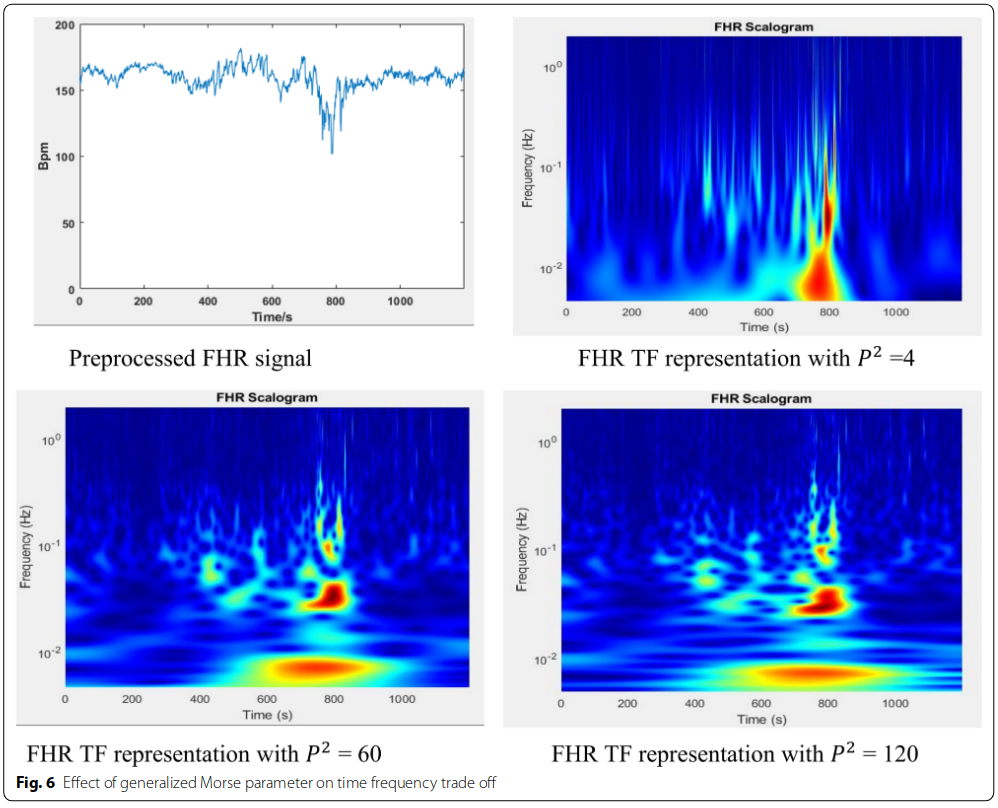

In [14]:
Image('images/daydulo_figure6.png')

In [15]:
# Import some FHR data
ctg = pd.read_csv('data_csv/1011.csv')
raw_fhr = ctg['FHR']
raw_uc = ctg['UC']

In [16]:
def daydulo_clean(fhr):
    '''
    Cleans fetal heart rate (FHR) signal according to Daydulo et al. 2022
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    '''

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using cubic interpolation
    fhr = fhr.interpolate(method='cubic')

    return(fhr)

**Caution:** The paper did not state which record was used to produce their figures. From visual inspection of some of the first few records, I have chosen one that looks fairly similar, but is not identical so likely not the same.

In [17]:
# Clean the FHR
fhr = daydulo_clean(raw_fhr)

# Extract first 20 minutes (4800) and last 15 minutes (3600)
fhr_first = fhr.head(20*60)
fhr_second = fhr.tail(15*60)

# Check signal length
print(len(fhr_first))
print(len(fhr_second))

1200
900


It says the signal length if 4800 and 3600, but mine work out to a quarter of that length - I am unclear why, as the length of time matches up.

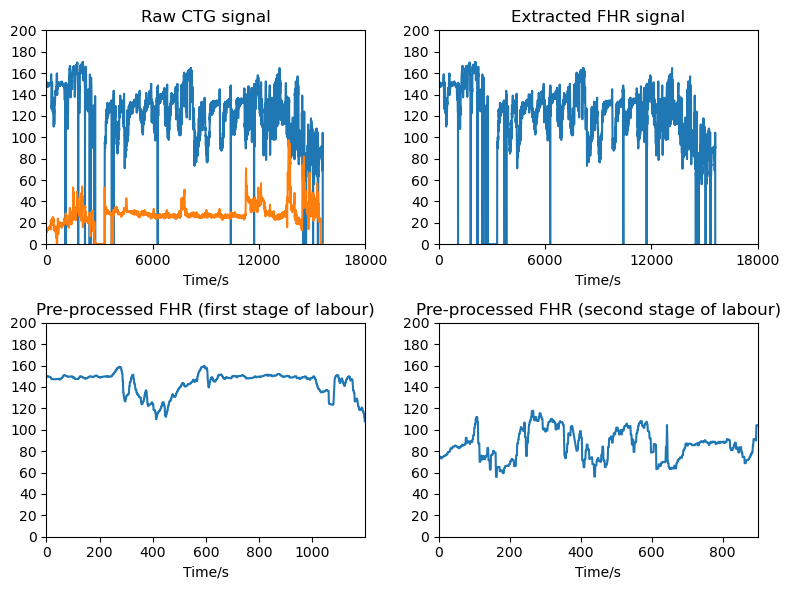

In [18]:
# Initialise plot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

# Plot raw FHR and UC
ax[0,0].plot(raw_fhr.fillna(0))
ax[0,0].plot(raw_uc.fillna(0))
ax[0,0].margins(x=0)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlabel('Time/s')
ax[0,0].set_title('Raw CTG signal')
ax[0,0].set_xticks([0, 6000, 12000, 18000])
ax[0,0].set_yticks(np.arange(0, 201, 20))

# Plot raw FHR
ax[0,1].plot(raw_fhr.fillna(0))
ax[0,1].margins(x=0)
ax[0,1].set_ylim(0, 200)
ax[0,1].set_xlabel('Time/s')
ax[0,1].set_title('Extracted FHR signal')
ax[0,1].set_xticks([0, 6000, 12000, 18000])
ax[0,1].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 1
ax[1,0].plot(fhr_first)
ax[1,0].margins(x=0)
ax[1,0].set_ylim(0, 200)
ax[1,0].set_xlabel('Time/s')
ax[1,0].set_title('Pre-processed FHR (first stage of labour)')
ax[1,0].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 2
ax[1,1].plot(fhr_second.reset_index(drop=True))
ax[1,1].margins(x=0)
ax[1,1].set_ylim(0, 200)
ax[1,1].set_xlabel('Time/s')
ax[1,1].set_title('Pre-processed FHR (second stage of labour)')
ax[1,1].set_yticks(np.arange(0, 201, 20))

plt.tight_layout()
plt.show()

I have matched the parameters used through ssqueezepy:
* Generalised Morse Wavelet
* Voices per octave 12
* γ = 3
* P<sup>2</sup> - ssqueezepy gmw accepts β. P<sup>2</sup> = βγ.
    * 4 = β*3, so β=0.75
    * 60 = β*3, so β=20
    * 120 = β*3, so β=40

This is starting to look very similar - I'm suspicious that if I'd found the correct record, that these would match!

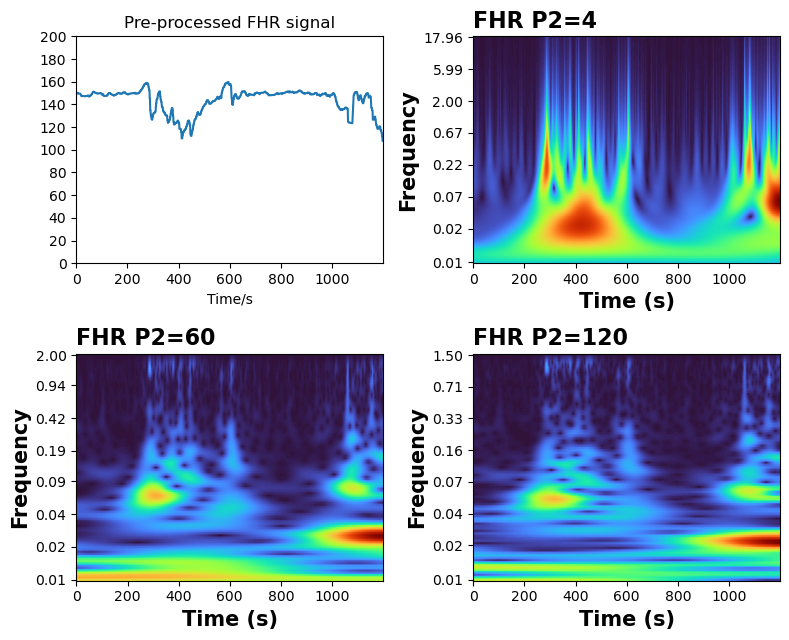

In [19]:
# Initialise plot
fig = plt.figure(figsize=(8, 6.5))

# Plot clean FHR stage 1
ax = fig.add_subplot(221)
ax.plot(fhr_first)
ax.margins(x=0)
ax.set_ylim(0, 200)
ax.set_xlabel('Time/s')
ax.set_title('Pre-processed FHR signal')
ax.set_yticks(np.arange(0, 201, 20))

def daydulo_cwt(beta, p2, axes):
    '''
    Perform CWT and plot scaleogram for replicating Daydulo at given values
    of beta and p2
    - beta: number, decay/compactness parameter, relates to p2
    - p2: number, time-bandwidth product
    - axes: subplot number
    '''
    # Set parameters
    signal_length = len(fhr_first)
    wavelet = Wavelet(('gmw', {'gamma': 3, 'beta':beta}))
    voices_per_octave = 12

    # Find scales
    min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
    scales = make_scales(signal_length, scaletype='log', nv=voices_per_octave,
                        min_scale=min_scale, max_scale=max_scale)

    # Perform CWT
    Wx, _ = cwt(fhr_first, wavelet, scales=scales)

    # Visualise
    ax = fig.add_subplot(axes)
    imshow(data=Wx, abs=1, show=False, yticks=1/scales,
           title=f'FHR P2={p2}', xlabel='Time (s)', ylabel='Frequency')


daydulo_cwt(0.75, 4, 222)
daydulo_cwt(20, 60, 223)
daydulo_cwt(40, 120, 224)

plt.tight_layout()
plt.show()

## ✖ Yang et al. 2021 - Unsupervised Detection of Anomalies in Fetal Heart Rate

Uses **phase space reconstruction** (which is a method I haven't explored).

* No signal filtering or artifact removal
* Morlet wavelet or Fabor
* Last 14,400 samples of the signals
* Created 100 x 14400 grey pixel image

## ✖ Zhao et al. 2019 - DeepFHR: intelligent prediction of fetal Acidemia using fetal heart rate signals based on convolutional neural network

Pre-processing:
* Spline interpolation when FHR=0
* If FHR=0 for more than 15s, then removed
* Interpolation between first sample of 2 adjacent points where difference is higher than 25bpm and still the first of the new stable section which is defined as a time series of five adjacent samples with the differences among them less than 10bpm
* Cubic spline interpolation to remove extreme (non-physiological) values less than 50bpm and over 200bpm
* Appears to take the first 20 minutes of the signal

CWT:
* Mother wavelets: db (Daubechies) and sym (symlet)
* Order of 2 (db2)
* Three wavelet scales of 4, 5 and 6 to enrich dataset (so final dataset have 2683 images)

For the figure, they used db2 and wavelet scale 24 on records 1011 and 1017.

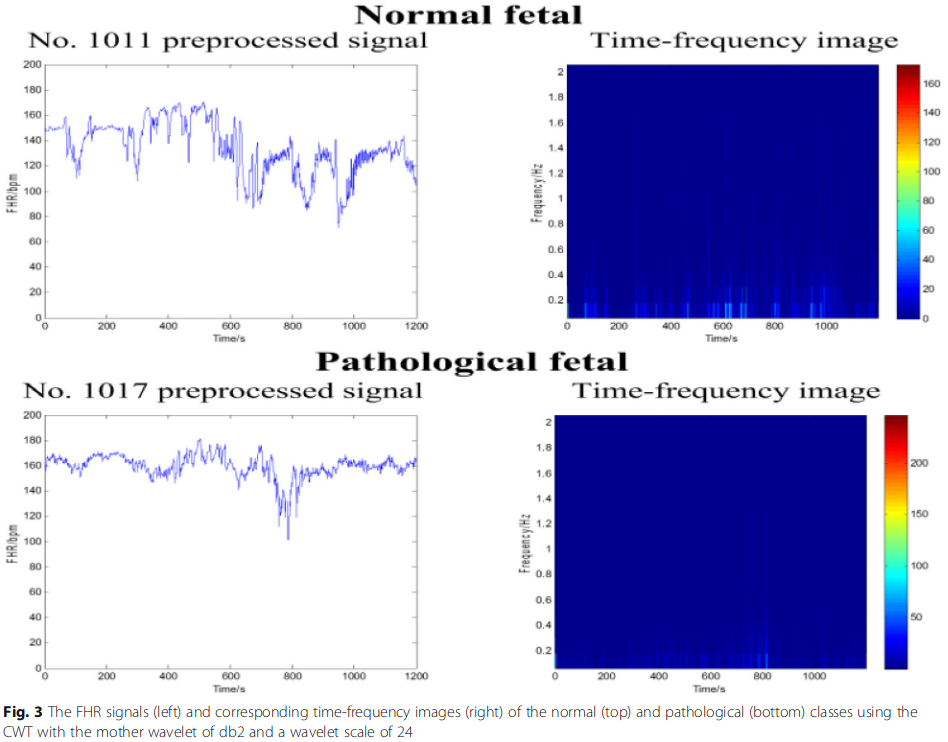

In [20]:
Image('images/zhao_fig3.png')

In [21]:
# Import some FHR data
raw_fhr_1011 = pd.read_csv('data_csv/1011.csv')['FHR']
raw_fhr_1017 = pd.read_csv('data_csv/1017.csv')['FHR']

pd.interpolate(method='spline') requires you to give an order, but the paper does not provide this, so I have just used 3 as it was in some example code online from something else.

In [22]:
def zhao_clean(fhr):
    '''
    Cleans fetal heart rate (FHR) signal according to Zhao et al. 2019
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    '''
    # Keep the first 20 minutes
    fhr = fhr.head(20*60*4)

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Spline interpolation of smaller gaps
    fhr = fhr.interpolate(method='spline', order=3)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using cubic interpolation
    fhr = fhr.interpolate(method='cubic')

    return(fhr)

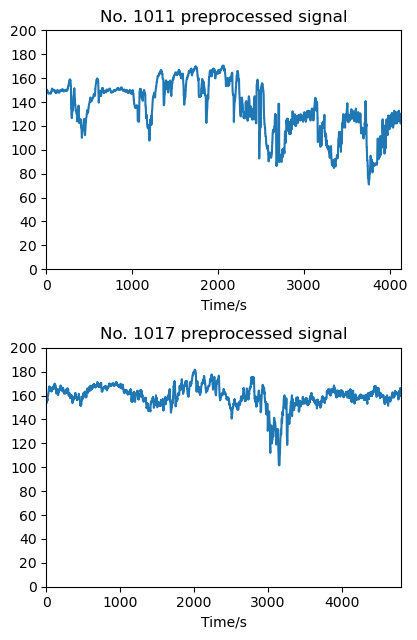

In [23]:
fhr_1011 = zhao_clean(raw_fhr_1011)
fhr_1017 = zhao_clean(raw_fhr_1017)

# Initialise plot
fig = plt.figure(figsize=(8, 6.5))

# Plot signal
ax = fig.add_subplot(221)
ax.plot(fhr_1011)
ax.margins(x=0)
ax.set_ylim(0, 200)
ax.set_xlabel('Time/s')
ax.set_title('No. 1011 preprocessed signal')
ax.set_yticks(np.arange(0, 201, 20))

# Plot signal
ax = fig.add_subplot(223)
ax.plot(fhr_1017)
ax.margins(x=0)
ax.set_ylim(0, 200)
ax.set_xlabel('Time/s')
ax.set_title('No. 1017 preprocessed signal')
ax.set_yticks(np.arange(0, 201, 20))

plt.tight_layout()
plt.show()

<mark>This looks very different is not multiply by extra 4 but when I do it matches... have I mislabelled records at some point? Or, is the answer to my confusion about the record length v.s. what CTU state, to do with the 4Hz stuff, and is it that each row is every quarter second and not every second, and that the issue is with the labels? As it was the first notebook that Mike created that labelled the index as seconds, and **not** the data itself? This would explain the issue above where signal length didn't match what daydulo said</mark>

ssqueezepy doesn't support db or sym wavelets for CWT.